# Comparing the temperature, salinity and density profiles as a function of dynamic height of the SR1b section and DIMES mooring data

In [ ]:
import pickle
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo
import gsw
import csaps
import warnings

## Section

In [2]:
# read in hydrographic section data
data = loadmat('data/SR1b_section/sr1b_all.mat')

icyc = np.where(data['buf_year'] != 1999)[1] # exclude 1999 # TODO: why?

buf_lat = data['buf_lat'][0,icyc]
buf_lon = data['buf_lon'][0,icyc]
buf_sal = data['buf_sal'][:,icyc]
buf_temp = data['buf_temp'][:,icyc]
buf_ptmp = data['buf_ptmp'][:,icyc]
buf_gamma = data['buf_gamma'][:,icyc]
buf_press = data['buf_press'].reshape(3000)
buf_year = data['buf_year'][:,icyc].reshape(316)

f = h5py.File('data/SR1b_section/sr1b_gamma.mat')
buf_gamma = f["gamma"][icyc,:].transpose()

In [3]:
# calculate absolute salinity and conservative temperature
buf_SA = gsw.SA_from_SP(buf_sal, buf_press.reshape(3000,1), buf_lon.reshape(1,316), buf_lat.reshape(1,316)) # absolute salinity
buf_CT = gsw.conversions.CT_from_t(buf_SA, buf_temp, buf_press.reshape(3000,1)) # conservative temperature

# compute baroclinic streamfunction
gpan_buf = -gsw.geo_strf_dyn_height(buf_SA, buf_CT, buf_press, 1500) # geopotential height anomaly / dynamic height anomaly
buf_phi1500 = abs(gpan_buf[249,:]) # index 250 is at 500 dbar

In [4]:
# define a dynamic height grid, and the width of the running window
iphi_section = np.arange(2.6, 8.67, 0.2)
win_width = 0.4

#press_section     = np.zeros((len(buf_press), len(iphi)))
SA_section        = np.zeros((len(buf_press), len(iphi_section)))
CT_section        = np.zeros((len(buf_press), len(iphi_section)))
gamma_section     = np.zeros((len(buf_press), len(iphi_section)))

for j in range(len(buf_press)):
    with warnings.catch_warnings(): # this will suppress all warnings in this block
        warnings.simplefilter("ignore")
        for i in range(len(iphi_section)):
            icyc = np.where((buf_phi1500 <= iphi_section[i] + win_width/2) & (buf_phi1500 >= iphi_section[i] - win_width/2))[0]

            phi_window = buf_phi1500[icyc]
            SA_window = buf_SA[j,icyc]
            CT_window = buf_CT[j,icyc]
            gamma_window = buf_gamma[j,icyc]

            # mean values
            SA_section[j,i] = np.nanmean(SA_window)
            CT_section[j,i] = np.nanmean(CT_window)
            gamma_section[j,i] = np.nanmean(gamma_window)

## Moorings

In [5]:
# read in mooring data
mooring_c = loadmat('data/DIMES_moorings/mooring_c.mat')['mooring_c']
pressure = mooring_c['P'][0][0][0]

In [6]:
# downsampling to daily values

def downsample(input_array, factor):
    # factor says how much to downsample, i.e. to go from quarter hourly to days we downsample by 24*4=96
    shape = input_array.shape
    output = np.zeros((shape[0], shape[1]//factor))
    for i in range(shape[0]):
        output[i,:] = np.nanmean(input_array[i,:].reshape(-1, factor), 1)
        
    return output

downsampling_factor = 96          # 24 * 4, quarterly measurements

with warnings.catch_warnings(): # this will suppress all warnings in this block
    warnings.simplefilter("ignore")
    mooring_c['CT'][0][0] = downsample(mooring_c['CT'][0][0], downsampling_factor)
    mooring_c['SA'][0][0] = downsample(mooring_c['SA'][0][0], downsampling_factor)
    mooring_c['gamma'][0][0] = downsample(mooring_c['gamma'][0][0], downsampling_factor)
    mooring_c['U'][0][0] = downsample(mooring_c['U'][0][0].T, downsampling_factor)
    mooring_c['V'][0][0] = downsample(mooring_c['V'][0][0].T, downsampling_factor)
     
length_of_array = mooring_c['CT'][0][0].shape[1]

In [7]:
CT = mooring_c['CT'][0][0]
SA = mooring_c['SA'][0][0]
gamma = mooring_c['gamma'][0][0]

In [8]:
# calculate baroclinic streamfunctions and use spatial data to deduce distance from southern edge of section

gpan_c  = -gsw.geo_strf_dyn_height(mooring_c['SA'][0][0], mooring_c['CT'][0][0], mooring_c['P'][0][0][0])
phi1500_c  = gpan_c[105] - gpan_c[5]
phi1500 = phi1500_c

In [9]:
# define a dynamic height grid, and the width of the running window
iphi = np.arange(5.2, 8.67, 0.2)
win_width = 0.4

SA_moorings        = np.zeros((len(pressure), len(iphi)))
CT_moorings        = np.zeros((len(pressure), len(iphi)))
gamma_moorings     = np.zeros((len(pressure), len(iphi)))

for j in range(len(pressure)):
    with warnings.catch_warnings(): # this will suppress all warnings in this block
        warnings.simplefilter("ignore")
        for i in range(len(iphi)):
            icyc = np.where((phi1500 <= iphi[i] + win_width/2) & (phi1500 >= iphi[i] - win_width/2))[0]

            phi_window = phi1500[icyc]
            SA_window = SA[j,icyc]
            CT_window = CT[j,icyc]
            gamma_window = gamma[j,icyc]

            # mean values
            SA_moorings[j,i] = np.nanmean(SA_window)
            CT_moorings[j,i] = np.nanmean(CT_window)
            gamma_moorings[j,i] = np.nanmean(gamma_window)

## Plots

In [10]:
phi_PF = 0.55 * 9.8
phi_SAF = 0.7 * 9.8

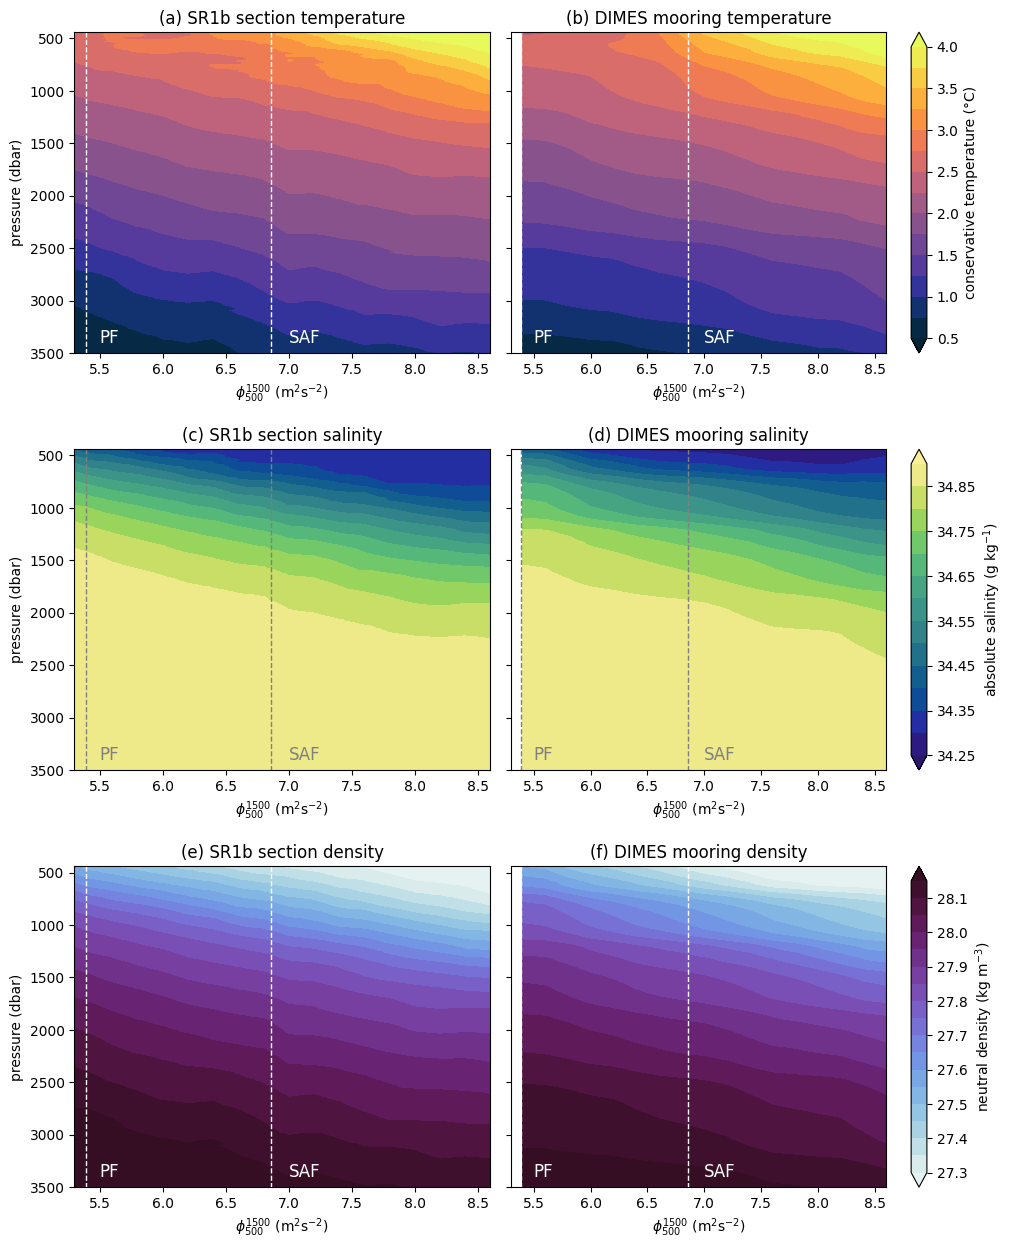

In [11]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(11, 15),sharey=True)

im1=ax1.contourf(iphi_section, buf_press, CT_section, levels=np.arange(0.5, 4.1, 0.25), cmap=cmo.cm.thermal,extend='both')
im2=ax2.contourf(iphi, pressure, CT_moorings, levels=np.arange(0.5, 4.1, 0.25), cmap=cmo.cm.thermal,extend='both')

im3=ax3.contourf(iphi_section, buf_press, SA_section,levels=np.arange(34.25, 34.91, 0.05), cmap=cmo.cm.haline,extend='both')
im4=ax4.contourf(iphi, pressure, SA_moorings, levels=np.arange(34.25, 34.91, 0.05), cmap=cmo.cm.haline,extend='both')

im5=ax5.contourf(iphi_section, buf_press, gamma_section, levels=np.arange(27.3, 28.2, 0.05), cmap=cmo.cm.dense,extend='both')
im6=ax6.contourf(iphi, pressure, gamma_moorings, levels=np.arange(27.3, 28.2, 0.05), cmap=cmo.cm.dense,extend='both')

divider2 = make_axes_locatable(ax2)
divider4 = make_axes_locatable(ax4)
divider6 = make_axes_locatable(ax6)
cax2 = divider2.append_axes("right", size="4.2%",pad=0.25)
cbar2 = fig.colorbar(im2,cax=cax2)
cbar2.set_label(r'conservative temperature (°C)')
cax4 = divider4.append_axes("right", size="4.2%",pad=0.25)
cbar4 = fig.colorbar(im4,cax=cax4)
cbar4.set_label(r'absolute salinity (g kg$^{-1}$)') 
cax6 = divider6.append_axes("right", size="4.2%",pad=0.25)
cbar6 = fig.colorbar(im6,cax=cax6)
cbar6.set_label(r'neutral density (kg m$^{-3}$)')

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    #ax.set_ylim(27.1,28.2)
    ax.set_xlim(5.3,8.6)
    ax.set_ylim(440,3500)
    ax.set_xlabel(r'$\phi^{1500}_{500}$ (m$^2$s$^{-2}$)')
    ax.invert_yaxis()
for ax in [ax1,ax3,ax5]:
    ax.set_ylabel(r'pressure (dbar)')
for ax in [ax1,ax2,ax5,ax6]:
    ax.vlines(phi_PF, ymin=440, ymax=3500, color='w', lw=1, ls='--')
    ax.vlines(phi_SAF, ymin=440, ymax=3500, color='w', lw=1, ls='--')
    ax.text(5.5,3400,'PF',c='w',fontsize=12)
    ax.text(7.0,3400,'SAF',c='w',fontsize=12)
for ax in [ax3,ax4]:
    ax.vlines(phi_PF, ymin=440, ymax=3500, color='grey', lw=1, ls='--')
    ax.vlines(phi_SAF, ymin=440, ymax=3500, color='grey', lw=1, ls='--')
    ax.text(5.5,3400,'PF',c='grey',fontsize=12)
    ax.text(7.0,3400,'SAF',c='grey',fontsize=12)

ax1.set_title('(a) SR1b section temperature')
ax2.set_title('(b) DIMES mooring temperature')
ax3.set_title('(c) SR1b section salinity')
ax4.set_title('(d) DIMES mooring salinity')
ax5.set_title('(e) SR1b section density')
ax6.set_title('(f) DIMES mooring density')

plt.subplots_adjust(wspace=0.05, hspace=0.3)
#plt.savefig('figures_paper/compare_data_sections_moorings.pdf',bbox_inches='tight')